In [1]:
#from mpl_toolkits.basemap import Basemap, cm
import os.path
import sys
from matplotlib import rcParams
from matplotlib.animation import ArtistAnimation
import matplotlib
import matplotlib.pyplot as plt
import pyart
from siphon.radarserver import RadarServer
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import pyart
import numpy as np
import numpy.ma as ma
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from metpy.calc import (bunkers_storm_motion, bulk_shear, dewpoint, dewpoint_rh, dry_lapse, moist_lapse, vapor_pressure, saturation_vapor_pressure,
                        get_wind_speed, get_wind_dir, pressure_to_height_std, mixing_ratio, cape_cin, get_wind_components,
                        height_to_pressure_std, equivalent_potential_temperature, parcel_profile, precipitable_water,
                        storm_relative_helicity, mean_pressure_weighted, most_unstable_cape_cin, most_unstable_parcel,
                        supercell_composite, significant_tornado, get_layer, relative_humidity_from_dewpoint)
from metpy.calc.tools import log_interp, get_layer, get_layer_heights
from metpy.calc import wind_direction
from metpy.units import units
from metpy.calc import lcl, log_interp
from metpy.calc import interp as metinterp
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
from metpy.plots import SkewT
from metpy.plots import Hodograph
import metpy.calc as metcalc

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

import pickle
import csv


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\graph\cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\graph\cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
#with open('SupercellSoundings/environment_null.csv', mode='w') as env_file:
#    env_writer = csv.writer(env_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)


In [3]:
def total_shear(u, v, heights, depth, bottom=0 * units.m,
                            storm_u=0 * units('m/s'), storm_v=0 * units('m/s')):
    r"""Calculate total shear. Will output both length of the hodograph over the layer and normalized shear.
    
    Parameters
    ----------
    u : array-like
        u component winds
    v : array-like
        v component winds
    heights : array-like
        atmospheric heights, will be converted to AGL
    depth : number
        depth of the layer
    bottom : number
        height of layer bottom AGL (default is surface)
    storm_u : number
        u component of storm motion (default is 0 m/s)
    storm_v : number
        v component of storm motion (default is 0 m/s)
    Returns
    -------
    `pint.Quantity`, `pint.Quantity`
        hodo_length, tot_shear
    """
    _, u, v, z = get_layer_heights(heights, depth, u, v, heights, with_agl=True, bottom=bottom)

    storm_relative_u = u - storm_u
    storm_relative_v = v - storm_v
    
    #Get storm-relative wind vectors for the middle of each layer,
    #as well as shear vectors for each layer
    sr_ushear = (storm_relative_u[1:] - storm_relative_u[:-1]) 
    sr_vshear = (storm_relative_v[1:] - storm_relative_v[:-1]) 
    
    layer_depths = (z[1:] - z[:-1])
    
    #Get magnitudes of the shear vectors, sum to get hodo length
    shear_mags = np.sqrt(sr_ushear**2 + sr_vshear**2)
    shear_mags_norm = np.sqrt(sr_ushear**2 + sr_vshear**2)/layer_depths
    hodo_length = np.sum(shear_mags)
    
    #Normalize by depth
    tot_shear = np.sum(shear_mags_norm)
    
    return (hodo_length*units('m/s'), tot_shear)

In [23]:
site = 'KFDR'
tor_nontor = 'NT'
year=2019
month=5
day=23
hour=0
time_start = datetime(year, month, day, hour, 0) # Our specified time
#cenlat = 37.7485
#cenlon = -98.9346
#Latlons for good 23z sounding
#cenlat = 33.2889
#cenlon = -87.5225
#Latlons for good 3/31 (4/1) 00z sounding
#cenlat = 33.5542
#cenlon = -87.1654

cenlat = 33.7071
cenlon = -98.6969
#cenlat = 47.2102
#cenlon = -96.4719
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)

In [24]:
#Change this to link for the RAP analysis dataset
#cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/catalog.html?dataset=rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/rap_130_'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'_'+str(time_start.hour)+'00_001.grb2')
cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#Have a link for the 20km RAP grid
#cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#And a link for the RUC analysis grids
#cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#Link to 20km RUC
#cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')

#cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/catalog.html?dataset=rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(UTC)+'_000.grb2')
latest_ds = list(cat.datasets.values())[0]
print(latest_ds.access_urls)
ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])

query = ncss.query()
query.variables('Vertical_velocity_pressure_isobaric').variables('Convective_available_potential_energy_surface').variables('u-component_of_wind_isobaric').variables('v-component_of_wind_isobaric').variables('Storm_relative_helicity_height_above_ground_layer').variables('Pressure_surface').variables('Dewpoint_temperature_height_above_ground').variables('Temperature_height_above_ground').variables('Vertical_u-component_shear_height_above_ground_layer').variables('Vertical_v-component_shear_height_above_ground_layer').variables('Geopotential_height_isobaric').variables('Geopotential_height_surface').variables('u-component_of_wind_height_above_ground').variables('v-component_of_wind_height_above_ground').variables('Relative_humidity_isobaric').variables('Temperature_isobaric').variables('MSLP_MAPS_System_Reduction_msl')
query.add_lonlat().lonlat_box(cenlon-2.1, cenlon +2.1, cenlat-2.1, cenlat+2.1)
data1 = ncss.get_data(query)
dtime = data1.variables['Geopotential_height_isobaric'].dimensions[0]
dlev = data1.variables['Geopotential_height_isobaric'].dimensions[1]
dlat = data1.variables['Geopotential_height_isobaric'].dimensions[2]
dlon = data1.variables['Geopotential_height_isobaric'].dimensions[3]
CAPE = np.asarray(data1.variables['Convective_available_potential_energy_surface'][:]) * units('J/kg')
SRH = np.asarray(data1.variables['Storm_relative_helicity_height_above_ground_layer'][:]) * units('m/s')
SFCP = (np.asarray(data1.variables['Pressure_surface'][:])/100.) * units('hPa')
Td = (np.asarray(data1.variables['Dewpoint_temperature_height_above_ground'][:]) * units('kelvin')).to('degC')
T = np.asarray(data1.variables['Temperature_height_above_ground'][:]) * units('kelvin')
#ushr = data1.variables['Vertical_u-component_shear_height_above_ground_layer'][:] * units('m/s')
#vshr = data1.variables['Vertical_v-component_shear_height_above_ground_layer'][:] * units('m/s')
hgt = np.asarray(data1.variables['Geopotential_height_isobaric'][:]) * units('meter')
sfc_hgt = np.asarray(data1.variables['Geopotential_height_surface'][:]) * units('meter')
uwnd = np.asarray(data1.variables['u-component_of_wind_isobaric'][:]) * units('m/s')
vwnd = np.asarray(data1.variables['v-component_of_wind_isobaric'][:]) * units('m/s')
Temp_up = np.asarray(data1.variables['Temperature_isobaric'][:]) * units('kelvin')
VVEL_up = np.asarray(data1.variables['Vertical_velocity_pressure_isobaric'][:]) * units('Pa/s')
RH_up = np.asarray(data1.variables['Relative_humidity_isobaric'][:])
usfc = np.asarray(data1.variables['u-component_of_wind_height_above_ground'][:]) * units('m/s')
vsfc = np.asarray(data1.variables['v-component_of_wind_height_above_ground'][:]) * units('m/s')
MSLP = (np.asarray(data1.variables['MSLP_MAPS_System_Reduction_msl'][:])/100.) * units('hPa')
# Get the dimension data
lats_r = data1.variables[dlat][:]
lons_r= data1.variables[dlon][:]
lev = (np.asarray(data1.variables[dlev][:])/100.) * units('hPa')

flon = float(cenlon)
flat = float(cenlat)
# Set up our array of latitude and longitude values and transform to 
# the desired projection.
crs = ccrs.PlateCarree()
crlons, crlats = np.meshgrid(lons_r[:]*1000, lats_r[:]*1000)
trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=265, central_latitude=25, standard_parallels=(25.,25.)),crlons,crlats)
trlons = trlatlons[:,:,0]
trlats = trlatlons[:,:,1]
dlon = np.abs(trlons - cenlon)
dlat = np.abs(trlats - cenlat)
ilon = np.where(dlon == np.min(dlon))
ilat = np.where(dlat == np.min(dlat))

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\siphon\catalog.py:268: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/rap130anl/201905/20190523/catalog.html?dataset=rap130anl/201905/20190523/rap_130_20190523_0000_000.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/rap130anl/201905/20190523/catalog.xml?dataset=rap130anl/201905/20190523/rap_130_20190523_0000_000.grb2
  new_url))


{'OPENDAP': 'https://www.ncei.noaa.gov/thredds/dodsC/rap130anl/201905/20190523/rap_130_20190523_0000_000.grb2', 'HTTPServer': 'https://www.ncei.noaa.gov/thredds/fileServer/rap130anl/201905/20190523/rap_130_20190523_0000_000.grb2', 'WCS': 'https://www.ncei.noaa.gov/thredds/wcs/rap130anl/201905/20190523/rap_130_20190523_0000_000.grb2', 'WMS': 'https://www.ncei.noaa.gov/thredds/wms/rap130anl/201905/20190523/rap_130_20190523_0000_000.grb2', 'NetcdfSubset': 'https://www.ncei.noaa.gov/thredds/ncss/rap130anl/201905/20190523/rap_130_20190523_0000_000.grb2', 'NCML': 'https://www.ncei.noaa.gov/thredds/ncml/rap130anl/201905/20190523/rap_130_20190523_0000_000.grb2', 'UDDC': 'https://www.ncei.noaa.gov/thredds/uddc/rap130anl/201905/20190523/rap_130_20190523_0000_000.grb2', 'ISO': 'https://www.ncei.noaa.gov/thredds/iso/rap130anl/201905/20190523/rap_130_20190523_0000_000.grb2'}


In [25]:
print(np.asarray(SFCP)*units('hPa'))

[[[926.8664 930.8664 935.8664 ... 988.8664 989.8664 990.8664]  [925.8664 927.8664 930.8664 ... 987.8664 989.8664 990.8664]  [924.8664 924.8664 929.8664 ... 987.8664 990.8664 992.8664]  ...  [895.8664 897.8664 901.8664 ... 973.8664 974.8664 976.8664]  [900.8664 901.8664 902.8664 ... 972.8664 973.8664 974.8664]  [907.8664 908.8664 908.8664 ... 973.8664 974.8664 975.8664]]] hectopascal


In [26]:
RH_prof = RH_up[0,:,ilat[0][0], ilon[1][0]]
Tdc_up = dewpoint_rh(Temp_up[0,:,ilat[0][0], ilon[1][0]],RH_up[0,:,ilat[0][0], ilon[1][0]]/100)
Omega = VVEL_up[0,:,ilat[0][0], ilon[1][0]]

p_sounding = np.sort(np.append(lev, SFCP[0,ilat[0][0], ilon[1][0]])) * SFCP.units
ind = np.where(p_sounding >= SFCP[0,ilat[0][0], ilon[1][0]])[0][0]
hgt_sounding = np.insert(hgt[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, sfc_hgt[0,ilat[0][0], ilon[1][0]].magnitude) * hgt.units
T_sounding = (np.insert(Temp_up[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, T[0,0,ilat[0][0], ilon[1][0]].magnitude) * T.units).to(Tdc_up.units)
Td_sounding = np.insert(Tdc_up.magnitude, ind, Td[0,0,ilat[0][0], ilon[1][0]].magnitude) * Tdc_up.units
u_sounding = np.insert(uwnd[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, usfc[0,0,ilat[0][0], ilon[1][0]].magnitude) * usfc.units
v_sounding = np.insert(vwnd[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, vsfc[0,0,ilat[0][0], ilon[1][0]].magnitude) * usfc.units

p_skewt = p_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
hgt_skewt = hgt_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
T_skewt = T_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
Td_skewt = Td_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
u_skewt = u_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]].to('kt')
v_skewt = v_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]].to('kt')
storm_motion = bunkers_storm_motion(p_skewt[::-1], u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1])

#Get RH for whole sounding
RH_skewt = relative_humidity_from_dewpoint(T_skewt, Td_skewt)


In [27]:
print(hgt_skewt)
#print(p_skewt)

[16482.258   15143.5     14042.377   13095.731   12255.357   11498.069 10806.241   10167.953    9572.139    9014.449    8489.718    7993.426  7521.854    7072.4893   6641.782    6228.6245   5833.211    5451.781  5084.3735   4730.3125   4385.9873   4053.951    3730.1445   3417.473  3114.2712   2820.3506   2535.3394   2258.26     1987.3047   1723.0459  1465.0225   1212.8038    965.8993    723.9398    486.6086    320.72803] meter


In [28]:
#wind_dir = wind_direction(u_skewt[:].magnitude, v_skewt[:].magnitude)
wind_dir = []
for i in range(len(u_skewt)):
    wdir = wind_direction(u_skewt[i], v_skewt[i])
    wind_dir.append(wdir.magnitude)
wind_dir = np.asarray(wind_dir)
wind_spd = get_wind_speed(u_skewt, v_skewt)

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\metpy\xarray.py:570: MetpyDeprecationWarning: The get_wind_speed function was deprecated in version 0.9. This function has been renamed wind_speed.
  return func(*args, **kwargs)


In [29]:
prof = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1]-hgt_skewt[-1], tmpc=T_skewt[::-1], 
                                    dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)

In [30]:
#Storm motion with 2014 Bunkers values
srwind = params.bunkers_storm_motion(prof)
print("Bunker's Storm Motion (right-mover) [deg,kts]:", utils.comp2vec(srwind[0], srwind[1]))
print("Bunker's Storm Motion (left-mover) [deg,kts]:", utils.comp2vec(srwind[2], srwind[3]))

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=240.37626846438394,
             mask=False,
       fill_value=-9999.0), 25.63069746239424)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=199.85888248246712,
             mask=False,
       fill_value=-9999.0), 43.41979969658783)


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\numpy\lib\function_base.py:1412: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


In [31]:
sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
#fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\sharppy-1.4.0_andover_alpha1-py3.7.egg\sharppy\sharptab\interp.py:54: RuntimeWarning: divide by zero encountered in log10
  return generic_interp_pres(np.log10(p), prof.logp[::-1], prof.hght[::-1])


In [32]:
print ("Most-Unstable CAPE:", mupcl.bplus) # J/kg
print ("Most-Unstable CIN:", mupcl.bminus) # J/kg
print ("Most-Unstable LCL:", mupcl.lclhght) # meters AGL
print ("Most-Unstable LFC:", mupcl.lfchght) # meters AGL
print ("Most-Unstable EL:", mupcl.elhght) # meters AGL
print ("Most-Unstable LI:", mupcl.li5) # C

Most-Unstable CAPE: 4983.660240646583
Most-Unstable CIN: -24.724913429094173
Most-Unstable LCL: 822.2687466537753
Most-Unstable LFC: 1144.29443359375
Most-Unstable EL: 14357.968651420604
Most-Unstable LI: -10.254344771982062


In [33]:
#Get MU and ML CAPE
mlcape = mlpcl.bplus
mucape = mupcl.bplus
#Get sfc-based lfc height
lfc = mlpcl.lfchght
#Get cin
cin = mlpcl.bminus
#Get parameters to match previous data
sfc = prof.pres[prof.sfc]

p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
p9km = interp.pres(prof, interp.to_msl(prof, 9000.))

srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])[0]
srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])[0]

#Get shear magnitudes
sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
sfc1shear = utils.mag( sfc_1km_shear[0], sfc_1km_shear[1] )
sfc3shear = utils.mag( sfc_3km_shear[0], sfc_3km_shear[1] )
sfc6shear = utils.mag( sfc_6km_shear[0], sfc_6km_shear[1] )

#Use MetPy to get the RH interpolations and pressure-weighted layers
mpwrh_13 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], heights=hgt_skewt[::-1]-hgt_skewt[-1], bottom=1000*units('meter'), depth=2000 * units.meter)[0].magnitude
mpwrh_36 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], heights=hgt_skewt[::-1]-hgt_skewt[-1], bottom=3000*units('meter'), depth=3000 * units.meter)[0].magnitude
mpwrh_69 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], heights=hgt_skewt[::-1]-hgt_skewt[-1], bottom=6000*units('meter'), depth=3000 * units.meter)[0].magnitude
#mpwrh_69 = np.nan
#Use MetPy to interpolate to the 3, 6, and 9km levels
rh3 = metinterp(3000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude
rh6 = metinterp(6000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude
rh9 = metinterp(9000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude

#Get 0C height from SharpPy
hgt0c = sfcpcl.hght0c
#Get convective temp
ctemp = params.convective_temp(prof)
#Add to a new profile and get the lcl from that (which becomes the ccl)
T_skewt_c = np.copy(T_skewt)
T_skewt_c[-1] = ctemp
profc = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1]-hgt_skewt[-1], tmpc=T_skewt_c[::-1], 
                                    dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)
sfcpclc = params.parcelx( profc, flag=1 ) # Surface Parcel for ccl
ccl = mlpcl.lclhght
#Interpolate temperature to the ccl height with MetPy
cclt = metinterp(ccl*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], T_skewt[::-1])[0].magnitude

#Get normal lcl height and t
lcl = mlpcl.lclhght
lclt = metinterp(lcl*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], T_skewt[::-1])[0].magnitude

#Get sigtor
sigtor = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km, utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])

#Get effective inflow stuff
eff_inflow = params.effective_inflow_layer(prof)
ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
effective_srh = winds.helicity(prof, ebot_hght, etop_hght, stu = srwind[0], stv = srwind[1])[0]
ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
ebwspd = utils.mag( ebwd[0], ebwd[1] )

#Get suepercell composite
scp = params.scp(mupcl.bplus, effective_srh, ebwspd)
#Get EHI
EHI = params.ehi(prof, sfcpcl, sfc, 3000, stu = srwind[0], stv = srwind[1])

#Do calculations for VGP
ts3 = total_shear(u_skewt[::-1].to('m/s'), v_skewt[::-1].to('m/s'), hgt_skewt[::-1]-hgt_skewt[-1], bottom=0 *units('m'),depth = 3000 * units('meter'))[1]
VGP = ts3.magnitude*(np.sqrt(sfcpcl.bplus))
print("MLCAPE", mlcape)
print('lcl z', lcl)
print('lfc z', lfc)
print('MUCAPE', mucape)
print('cin', cin)
print("ESRH", effective_srh)
print('ESHR', ebwspd)
print("scp", scp)
print('sigtor',sigtor)
print('rh3',rh3)
print('rh6',rh6)
print('rh9',rh9)
print("p3",p3km)
print("p6",p6km)
print("p9",p9km)
print('RH 1-3', mpwrh_13)
print('RH 3-6', mpwrh_36)
print('RH 6-9', mpwrh_69)
print('0C Z',hgt0c)
print('CCL T',cclt)
print('LCL T',lclt)
print('DD Depth')
print('DD Center')
print('Cap Top')
print('Cap Max T')
print('Cap Max T Height')
print('0-1 SRH', srh1km)
print('0-3 SRH', srh3km)
print('0-1 Shear', sfc1shear)
print('0-3 Shear', sfc3shear)
print('0-6 Shear', sfc6shear)
print("EHI", EHI)
print('VGP', VGP)

MLCAPE 4519.95458734423
lcl z 1096.0100303547756
lfc z 1402.31787109375
MUCAPE 4983.660240646583
cin -5.280527480431839
ESRH 252.79836571255385
ESHR 23.562302430703554
scp 25.19722328204178
sigtor 6.782523473266233
rh3 0.18922147504158887
rh6 0.16292652966675245
rh9 0.17001447056010155
p3 682.8783915593566
p6 469.3091995341519
p9 311.0228137532319
RH 1-3 0.7369336286413226
RH 3-6 0.1289583501192291
RH 6-9 0.1713044593885799
0C Z 4534.897129781945
CCL T 20.614777297397268
LCL T 20.614777297397268
DD Depth
DD Center
Cap Top
Cap Max T
Cap Max T Height
0-1 SRH 204.142833151471
0-3 SRH 284.1324775106335
0-1 Shear 22.80460847242671
0-3 Shear 31.665439099176634
0-6 Shear 47.187162491284624
EHI 2.648537842911335
VGP 8.84939363544167


In [34]:
#Questions about data:
#Are LCL, LFC, and CIN from a sfc or mixed parcel?
#How are the DD parameters calculated?
#Where do the cap parameters come from?
#Is EHI 0-3km?


In [35]:
#Extract a parcel profile from SharpPy
profile1 = mlpcl.ttrace*units('degC')
pprofile1 = mlpcl.ptrace*units('hPa')
vtemp_pr = prof.vtmp

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\metpy\xarray.py:570: MetpyDeprecationWarning: The interp function was deprecated in version 0.9. This function has been moved to metpy.interpolate and renamed interpolate_1d.
  return func(*args, **kwargs)


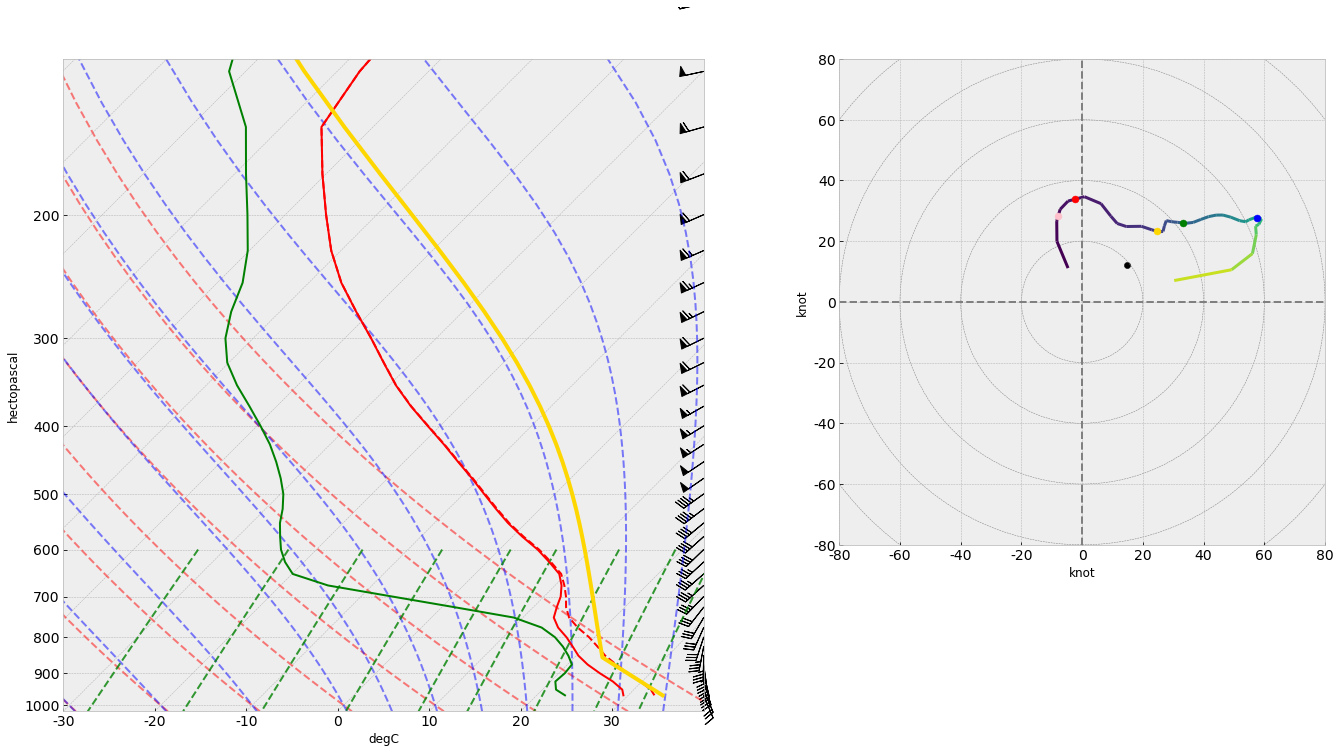

In [36]:
#%matplotlib inline
plt.style.use('bmh')
#plt.title('21 UTC NARR Sounding 31 May 1985 Wheatland, PA')
# Change default to be better for skew-T
fig = plt.figure(figsize=(24, 12))
#skew = SkewT(fig)
gs = gridspec.GridSpec(8, 4)
skew = SkewT(fig, rotation=45, subplot=gs[:, :2])
skew.plot(p_skewt, T_skewt, 'r')
skew.plot(p_skewt, vtemp_pr[::-1], 'r', linestyle='--')
skew.plot(p_skewt, Td_skewt, 'g')
skew.plot_barbs(p_skewt, u_skewt, v_skewt)

#profile1 = metcalc.parcel_profile(p_skewt[::-1], T_skewt[::-1], Td_skewt[::-1]).to('degC')
#Plot the most unstable parcel path
#skew.plot(pres_mu, mu_profile, 'orange', linewidth=4, linestyle = '--')
#Plot the parcel path
skew.plot(pprofile1, profile1, 'gold', linewidth=4)


#Let's try to fill between the profile and parcel path.
#greater = Tc >= prof
#skew.ax.fill_betweenx(levc, Tc, prof, where=greater, facecolor='blue', alpha=0.4)
#skew.ax.fill_betweenx(levc, Tc, prof, where=~greater, facecolor='red', alpha=0.4)

skew.ax.set_ylim(1020, 120)
# Good bounds for aspect ratio
skew.ax.set_xlim(-30, 40)
skew.ax.set_xticklabels([-110,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30], size = 14)
skew.ax.set_yticklabels([100,200,300,400,500,600,700,800,900,1000],size = 14)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

ax1 = fig.add_subplot(gs[:6, 2:])
h = Hodograph(ax1,component_range=80.)
h.add_grid(increment=20)
c = h.plot_colormapped(u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1]-hgt_skewt[-1])
#cl = h.plot_colormapped(u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1], bounds = [0, 1000, 3000, 5000, 10000] * units('meter'),
#             colors = ['magenta', 'red', 'yellow', 'green'], linewidth = 4)
#cl = h.plot_colormapped(u_skewt[::-1], v_skewt[::-1], np.asarray(hgt_skewt[::-1]), bounds = np.asarray([0, 1000, 3000, 5000, 10000]) * units('meter'), colors = ['magenta', 'red', 'yellow', 'green'], linewidth = 4)
#Interpolate the wind levels
hgt_points = metinterp([500, 1000, 3000, 5000, 10000]*units('meter'),hgt_skewt[::-1]-hgt_skewt[-1], u_skewt[::-1], v_skewt[::-1])
h.ax.scatter(storm_motion[0][0].to('knots'), storm_motion[0][1].to('knots'), s = 38, color = 'k')
h.ax.scatter(hgt_points[0][0], hgt_points[1][0], s = 48, color = 'pink', zorder=10)
h.ax.scatter(hgt_points[0][1], hgt_points[1][1], s = 48, color = 'r', zorder=10)
h.ax.scatter(hgt_points[0][2], hgt_points[1][2], s = 48, color = 'gold', zorder=10)
h.ax.scatter(hgt_points[0][3], hgt_points[1][3], s = 48, color = 'green', zorder=10)
h.ax.scatter(hgt_points[0][4], hgt_points[1][4], s = 48, color = 'blue', zorder=10)

#cb = plt.colorbar(cl, shrink = .8)
#cb.ax.set_yticklabels(['sfc','1,000','3,000','5,000','10,000'])
#cb.set_label('Height AGL (m)')
h.ax.set_xticklabels([-80,-60,-40,-20,0,20,40,60,80],size = 14)
h.ax.set_yticklabels([-80,-60,-40,-20,0,20,40,60,80],size = 14)

plt.show()

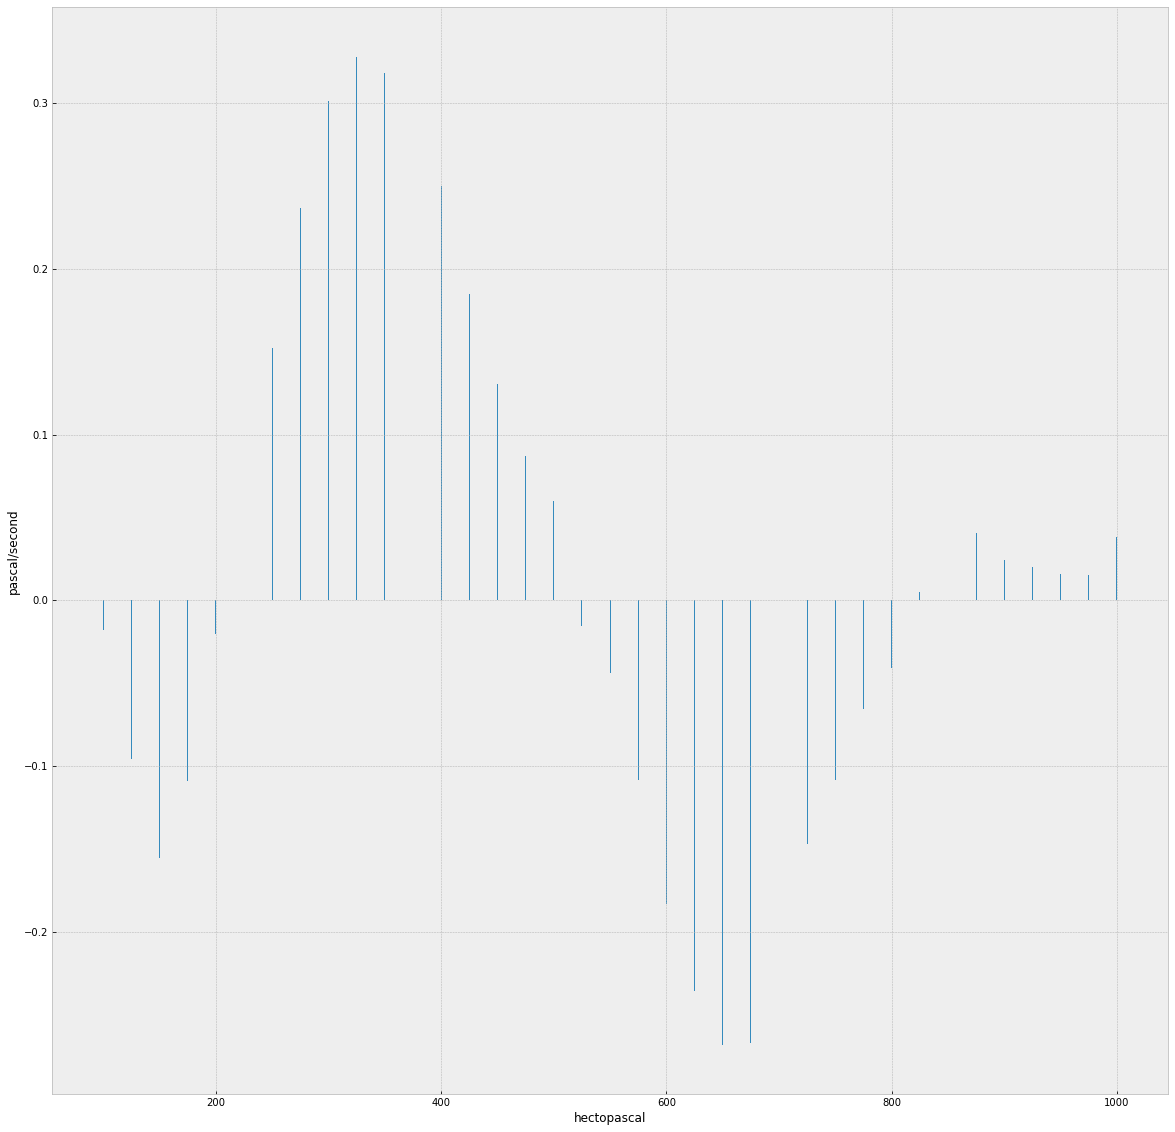

In [37]:
fig=plt.figure(2,figsize=(20.,20.))
plt.bar(lev, Omega)
plt.show()

In [38]:
print([site, year, month, day, hour, tor_nontor, mlcape, lcl, lfc, mucape, cin, effective_srh, ebwspd, scp, sigtor, rh3, rh6, rh9, p3km, p6km, p9km, mpwrh_13, mpwrh_36, mpwrh_69, hgt0c, cclt, lclt, srh1km, srh3km, sfc1shear, sfc3shear, sfc6shear, EHI, cenlat, cenlon])

['KFDR', 2019, '05', 23, '00', 'NT', 4519.95458734423, 1096.0100303547756, 1402.31787109375, 4983.660240646583, -5.280527480431839, 252.79836571255385, 23.562302430703554, 25.19722328204178, 6.782523473266233, 0.18922147504158887, 0.16292652966675245, 0.17001447056010155, 682.8783915593566, 469.3091995341519, 311.0228137532319, 0.7369336286413226, 0.1289583501192291, 0.1713044593885799, 4534.897129781945, 20.614777297397268, 20.614777297397268, 204.142833151471, 284.1324775106335, 22.80460847242671, 31.665439099176634, 47.187162491284624, 2.648537842911335, 33.7071, -98.6969]


In [39]:
#Save the whole sounding to a pickle file
#Save pressure, height, temperature, dewpoint, u, and v
sounding_array = np.zeros((6, len(p_skewt)))
sounding_array[0,:]=p_skewt
sounding_array[1,:]=hgt_skewt
sounding_array[2,:]=T_skewt
sounding_array[3,:]=Td_skewt
sounding_array[4,:]=u_skewt
sounding_array[5,:]=v_skewt
#Save to pickle
with open('SupercellSoundingsNew/sounding'+str(site)+'_'+str(month)+'_'+str(day)+'_'+str(year)+'_'+str(hour)+'z.pkl', 'wb') as f:
    pickle.dump(sounding_array, f)
    
#Write environmental parameters to csv
with open('SupercellSoundingsNew/environment_cicases1022.csv', mode='a') as env_file:
    env_writer = csv.writer(env_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    env_writer.writerow([site, year, month, day, hour, tor_nontor, mlcape, lcl, lfc, mucape, cin, effective_srh, ebwspd, scp, sigtor, rh3, rh6, rh9, p3km, p6km, p9km, mpwrh_13, mpwrh_36, mpwrh_69, hgt0c, cclt, lclt, srh1km, srh3km, sfc1shear, sfc3shear, sfc6shear, EHI, cenlat, cenlon])

In [21]:
print(hgt_skewt-hgt_skewt[-1])

[16182.789   14847.26    13760.232   12826.719   11995.455   11240.609 10548.104    9906.199    9305.342    8744.242    8216.213    7716.4507  7242.268    6791.759    6360.7065   5948.0557   5553.481    5173.0117  4808.6      4457.861    4119.679    3793.3442   3477.323    3171.9304  2874.5718   2585.923    2304.7744   2031.0583   1764.2798   1503.7952  1249.193    1000.2505    756.55273   517.64984   283.31372    53.46173     0.     ] meter


In [22]:
print(T_skewt)

[-66.66333    -70.107574   -67.90825    -63.63063    -56.900513 -51.41382    -45.694305   -39.714645   -35.4373     -31.757965 -27.55391    -23.66983    -20.315659   -17.252014   -14.151642 -10.928619    -8.537537    -6.462921    -4.9084473   -3.197113  -1.3451538    0.37905884   2.11911      4.1180115    6.187195   8.404938    10.188904    11.834839    14.077972    15.92923  17.711182    19.431793    21.435272    23.61734     25.729218  27.568756    27.966278  ] degC


In [117]:
print(Td_skewt)

[-83.34835   -79.684     -70.71897   -64.089455  -62.52524   -60.15095 -54.97087   -53.085323  -51.338963  -49.944767  -49.83786   -51.123714 -52.80833   -55.894077  -62.046097  -60.01785   -52.527912  -40.522583 -32.4757    -24.758385  -17.14883   -11.249289   -9.442361   -8.975606 -10.782319   -7.8689046  -2.4697924   4.400269    9.884827   12.262582  13.077029   14.221559   15.859105   16.555563   16.996735 ] degC


In [143]:
import numpy

In [26]:
numpy.version.version

'1.17.3'

In [1636]:
print(srwind)

(nan, nan, nan, nan)
